In [1]:
import gymnasium as gym
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
import diffrax
from scipy.ndimage import zoom


from pde_opt.numerics.domains import Domain
from pde_opt.rl_utils import detect_vortices, density
from pde_opt.numerics.equations.gross_pitaevskii import (
    GPE2DTSControl,
    hbar,
    mass_Na23,
    a0,
)
from pde_opt.numerics.solvers import StrangSplitting
from pde_opt.numerics.utils.initialization_utils import initialize_Psi

In [2]:
# Get variables with dimensions
atoms = 5e5  # number of atoms
omega = 2 * jnp.pi * 10  # 1/s (angular frequency of the trap in the x and y directions)
omega_z = jnp.sqrt(8) * omega  # 1/s (angular frequency of the trap in the z direction)
epsilon = 0.0  # eccentricity of the trap
a_s = 100 * a0  # s-wave scattering length

# Length of the x and y axes in meters
Lx = 150e-6  # meters
Ly = 150e-6  # meters

x_s = jnp.sqrt(hbar / (mass_Na23 * omega))  # length scale
t_s = 1 / omega  # time scale

# Get dimensionless variables
Lx_ = Lx / x_s
Ly_ = Ly / x_s

# Get k
k = (
    4 * jnp.pi * a_s * atoms * jnp.sqrt((mass_Na23 * omega_z) / (2 * jnp.pi * hbar))
)  # dimensionless coupling constant

N = 256  # number of grid points
domain_ = Domain(
    (
        N,
        N,
    ),
    (
        (-Lx_ / 2, Lx_ / 2),
        (-Ly_ / 2, Ly_ / 2),
    ),
    "dimensionless",
)

In [3]:
Psi0 = initialize_Psi(N, width=100, vortexnumber=0)
Psi0_ = Psi0 * x_s
Psi0_ /= jnp.sqrt(jnp.sum(density(Psi0_)) * domain_.dx[0] ** 2)

In [4]:
eq = GPE2DTSControl(domain_, k, epsilon, lambda a, b, c: 0.0, trap_factor=1.0)
solver = StrangSplitting(eq.A_term, eq.domain.dx[0], eq.fft, eq.ifft, -1j)

In [5]:
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(jax.jit(lambda t, y, args: eq.B_terms(y, t))),
    solver,
    t0=0.0,
    t1=0.05 / t_s,
    dt0=1e-5 / t_s,
    y0=jnp.stack([Psi0_.real, Psi0_.imag], axis=-1),
    saveat=diffrax.SaveAt(t1=True),
    max_steps=1000000,
)

ground_state = solution.ys[-1]

In [6]:
end_time = 1.0 / t_s
step_dt = 0.01 / t_s
numeric_dt = 1e-5 / t_s

In [7]:
def reset_function(domain):
    if ground_state.shape[:-1] != domain.points:
        # Reshape ground_state to match domain points
        zoom_factors = (
            domain.points[0] / ground_state.shape[0],
            domain.points[1] / ground_state.shape[1],
        )
        resized = zoom(ground_state, zoom_factors, order=1)
        return resized
    return ground_state


reset_control_value = (0.0, 0.0)


def state_to_observation(state):
    _density = density(state[..., 0] + 1j * state[..., 1])
    return (np.clip(np.array(_density), 0, 0.01) * 100 * 255).astype(np.uint8)[None]


# reward function
def reward_function(state):
    psi = state[..., 0] + 1j * state[..., 1]
    vorts = detect_vortices(psi, amp_thresh=0.00005, tol=0.5)
    return vorts["num_vortices"]


continuous_action_space_config = {
    "type": "continuous",
    "shape": (2,),
    "low": float(-1e-5 / x_s),
    "high": float(1e-5 / x_s),
}

discrete_action_space_config = {
    "type": "discrete",
    "num_actions": 5,
    "action_mapping": {
        0: (0.0, 0.0),  # no change
        1: (-0.5e-5 / x_s, 0.0),  # move left
        2: (0.5e-5 / x_s, 0.0),  # move right
        3: (0.0, -0.5e-5 / x_s),  # move down
        4: (0.0, 0.5e-5 / x_s),  # move up
    },
}


def update_control_value(action, old_control_value):
    return (old_control_value[0] + action[0], old_control_value[1] + action[1])


def update_control_parameter(old_control_value, new_control_value):
    path_fn = lambda t: (
        old_control_value[0]
        + (new_control_value[0] - old_control_value[0]) * t / step_dt,
        old_control_value[1]
        + (new_control_value[1] - old_control_value[1]) * t / step_dt,
    )

    def light(t, xs, ys):
        A = 30.0
        sigma = 2e-6 / x_s
        xi, yi = path_fn(t)
        return A * jnp.exp(-((xs - xi) ** 2 + (ys - yi) ** 2) / (2.0 * sigma**2))

    return light


static_equation_parameters = {
    "k": k,
    "e": epsilon,
    "trap_factor": 1.0,
}

solver_parameters = {
    "time_scale": (1.0 - 1j * 0.01),
}

params = {
    "equation_type": GPE2DTSControl,
    "domain": domain_,
    "solver_type": StrangSplitting,
    "end_time": end_time,
    "step_dt": step_dt,
    "numeric_dt": numeric_dt,
    "state_to_observation_func": state_to_observation,
    "reward_function": reward_function,
    "reset_func": reset_function,
    "reset_control_value": reset_control_value,
    "update_control_value": update_control_value,
    "update_control_parameter": update_control_parameter,
    "action_space_config": continuous_action_space_config,
    "static_equation_parameters": static_equation_parameters,
    "control_equation_parameter_name": "lights",
    "solver_parameters": solver_parameters,
}

In [8]:
env = gym.make("PDEEnv-v0", **params)

In [9]:
observation, info = env.reset()

episode_over = False
rewards = []
total_reward = 0

iters = 0

observations = [observation[0]]
states = [info["state"]]
actions = []
positions = [(0, 0)]  # Start at origin
current_pos = [0, 0]

while not episode_over:
    action = env.action_space.sample()
    actions.append(action)
    observation, reward, terminated, truncated, info = env.step(action)

    total_reward += reward
    episode_over = terminated or truncated
    iters += 1
    rewards.append(reward)
    observations.append(observation[0])
    states.append(info["state"])
    current_pos[0] += action[1]
    current_pos[1] -= action[0]
    positions.append((current_pos[0], current_pos[1]))


print(f"Episode finished! Total reward: {total_reward}")
env.close()

Episode finished! Total reward: 408


In [ ]:
positions = np.array(positions)

In [162]:
ind = 60

In [163]:
psi = states[ind][..., 0] + 1j * states[ind][..., 1]
vorts = detect_vortices(psi, amp_thresh=0.00005, tol=0.5)
print(vorts["num_vortices"])

8


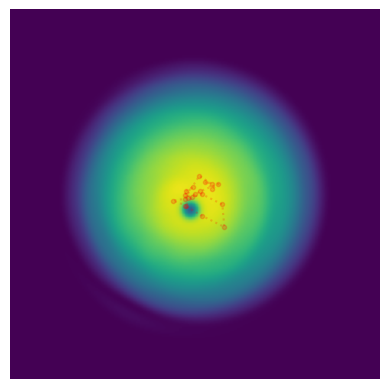

In [155]:
# Plot final observation with trajectory
plt.imshow(
    observations[ind],
    vmin=0,
    vmax=255,
    extent=[domain_.box[0][0], domain_.box[0][1], domain_.box[1][0], domain_.box[1][1]],
)
plt.plot(positions[:ind, 0], positions[:ind, 1], "r:", alpha=0.2)
plt.plot(positions[:ind, 0], positions[:ind, 1], "r.", alpha=0.2)
plt.scatter(
    vorts["positions"][:, 1] * domain_.dx[0] + domain_.box[0][0],
    -vorts["positions"][:, 0] * domain_.dx[1] + domain_.box[1][1],
    c='none',
    s=150,
    marker="o",
    linewidths=1,
    edgecolors=['black' if charge == -1 else 'white' for charge in vorts["charges"]]
)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.show()

In [96]:
vorts["charges"]

Array([-1,  1, -1,  1, -1,  1,  1], dtype=int32)

In [43]:
domain_.box

((Array(-11.335702, dtype=float32, weak_type=True),
  Array(11.335702, dtype=float32, weak_type=True)),
 (Array(-11.335702, dtype=float32, weak_type=True),
  Array(11.335702, dtype=float32, weak_type=True)))